# Basins of attraction

In [1]:
from model import * 
import numpy as np
from scipy.integrate import odeint


import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
plt.rcParams.update({'lines.markeredgewidth': 1})

In [2]:


# Function to calcualte the basin of attraction for the steady state
def basins_of_attratction(parameters ,vars=[0,1], log2_concentation_range=[-1,1], 
                          n_points=10, t_max=500, concentration_noise=0.0,
                          n_time_points=1000, clamped=False):
    
    # Generate a list of points that are on boundary of a box in the concentration space
    # The box is defined by the log2_concentration_range
    # The number of points is defined by n_points
    if len(log2_concentation_range) == 2:
        log_concentrations = np.linspace(log2_concentation_range[0], log2_concentation_range[1], n_points)
        concentrations = 2**log_concentrations
        # Create a list of all the points on the boundary of the box
        boundary_points = []
        for i in range(n_points):
            for j in range(n_points):
                if i == 0 or i == n_points-1 or j == 0 or j == n_points-1:
                    boundary_points.append([concentrations[i], concentrations[j]])
                    
    if len(log2_concentation_range) == 4:
        log_concentrations_x = np.linspace(log2_concentation_range[0], log2_concentation_range[1], n_points)
        log_concentrations_y = np.linspace(log2_concentation_range[2], log2_concentation_range[3], n_points)
        concentrations_x = 2**log_concentrations_x
        concentrations_y = 2**log_concentrations_y
        # Create a list of all the points on the boundary of the box
        boundary_points = []
        for i in range(n_points):
            for j in range(n_points):
                if i == 0 or i == n_points-1 or j == 0 or j == n_points-1:
                    boundary_points.append([concentrations_x[i], concentrations_y[j]])  

    # Time vector
    t = np.linspace(0,t_max,n_time_points)

    # Calculate the trajectories for each of the boundary points
    results = []
    for point in boundary_points:
        X0 = reference_state(concentration_noise)
        X0[vars[0]] = point[0]
        X0[vars[1]] = point[1]

        if not 3 in vars:
            # Calculate the insulin concentration
            X0[3] = insulin(X0[0], 1.0, 0.0)
        else:
            X0[3] = point[vars.index(3)] * insulin(1.0, 1.0, 0.0)
            
        if clamped:
            result = odeint(equation_clamped,X0, t, args=(parameters,))
        else:
            result = odeint(equation,X0, t, args=(parameters,))
        results.append(result)

    return t, results

In [3]:
p = reference_parameters( concentration_noise=0.0, flux_noise=0.0, ki_noise=0) 

# Amplitude emperical to match wons measurements 
t_pulse, result_pulse = insulin_pulse(p, t_max=150, n_data=2000, concentration_noise=0.0, pulse_time=2, pulse_amplitude=10.0)

# Insulin clamp trajectory to plot 
p_infusion_2 = change_parameters(p, e=[2*insulin(1,1,0)], ix=["deltaI"])
t, res_2 = response(p_infusion_2, t_max=120, n_data=1000, concentration_noise=0, clamped=True)

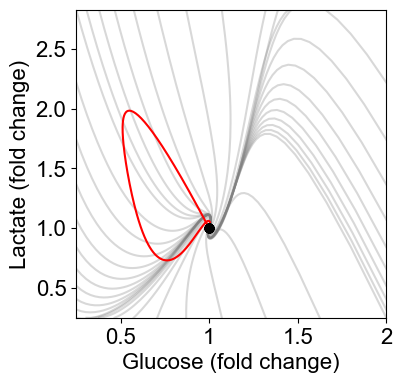

In [4]:
##############################################
# Figure 6 C                                #
##############################################

# Basins of attraction for the model   

# Plot dxdt on the 2D grid with quiver
plt.figure(figsize=(4,4))
# make the plot square 
#plt.axis('equal')

log2_concentation_range = [-2,1,-2,1.5]

t, basins = basins_of_attratction(p, vars=[0,1], log2_concentation_range=log2_concentation_range, 
                                  n_points=11, t_max=1000, concentration_noise=0.0, n_time_points=2000)

# Plot the basins of attraction

steady_states = []
for i, basin in enumerate(basins):
    plt.plot(basin[:,0], basin[:,1], 'grey', alpha=0.3 )
    steady_states.append(basin[-1])

# Plot the insulin pulse trajectory
plt.plot(result_pulse[:,0], result_pulse[:,1], 'r', label="Insulin pulse")


# plot the steady state as dots
steady_states = np.array(steady_states)
plt.plot(steady_states[:,0], steady_states[:,1], 'ko')

plt.xlim( 2**log2_concentation_range[0], 2**log2_concentation_range[1])
plt.ylim( 2**log2_concentation_range[2], 2**log2_concentation_range[3])

# Make Xticks and Yticks the same [0.5 ,1, 1.5 2]
plt.xticks([0.5, 1, 1.5, 2], [0.5, 1, 1.5, 2])
#plt.yticks([0.5, 1, 1.5, 2], [0.5, 1, 1.5, 2])

plt.xlabel('Glucose (fold change)')
plt.ylabel('Lactate (fold change)')

plt.savefig('output/basins_of_attraction_lactate_glucose.svg')


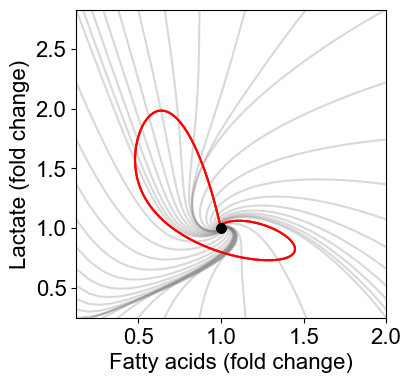

In [5]:
##############################################
# Figure 6 D                                 #
##############################################

# Plot dxdt on the 2D grid with quiver
plt.figure(figsize=(4,4))
# make the plot square 

log2_concentation_range = [-3,1,-2,1.5]

t, basins = basins_of_attratction(p, vars=[2,1], log2_concentation_range=log2_concentation_range, 
                                  n_points=11, t_max=1000, concentration_noise=0.0, n_time_points=2000)


# Plot the insulin pulse trajectory
plt.plot(result_pulse[:,2], result_pulse[:,1], 'r', label="Insulin pulse")


n = 40
m = 5
steady_states = []
for i, basin in enumerate(basins):
    plt.plot(basin[:,2], basin[:,1], 'grey', alpha=0.3)
    steady_states.append(basin[-1])
    
plt.plot(result_pulse[:,2], result_pulse[:,1], 'r', label="Insulin pulse")

# plot the steady state as dots
steady_states = np.array(steady_states)
plt.plot(steady_states[:,0], steady_states[:,1], 'ko')

# Move the legend outside the plot and to the top, right

#plt.legend([ "Insulin pulse",'Insulin clamp', "Basins of attraction"],) #loc='upper right', bbox_to_anchor=(1.8, 1.0))
plt.xlim( 2**log2_concentation_range[0], 2**log2_concentation_range[1])
plt.ylim( 2**log2_concentation_range[2], 2**log2_concentation_range[3])

plt.xlabel('Fatty acids (fold change)')
plt.ylabel('Lactate (fold change)')


# Make Xticks and Yticks the same [0.5 ,1, 1.5 2]
#plt.xticks([0.5, 1, 1.5, 2], [0.5, 1, 1.5, 2])
#plt.yticks([0.5, 1, 1.5, 2], [0.5, 1, 1.5, 2])

plt.savefig('output/basins_of_attraction_lactate_nefa.svg')


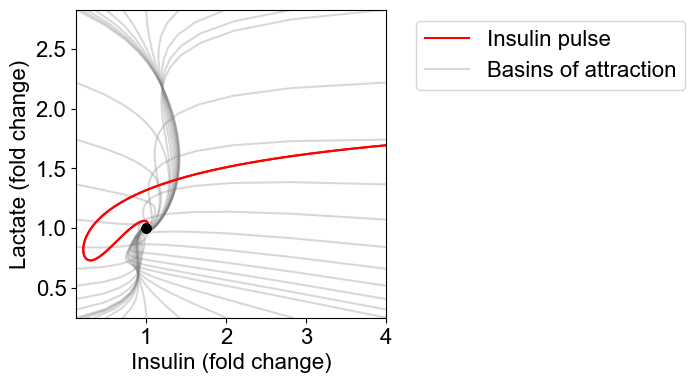

In [6]:
##############################################
# Figure 6 E                                 #
##############################################

# Plot dxdt on the 2D grid with quiver
plt.figure(figsize=(4,4))
# make the plot square 
#plt.axis('equal')

log2_concentation_range = [-3,2,-2,1.5]

t, basins = basins_of_attratction(p, vars=[3,1], log2_concentation_range=log2_concentation_range, 
                                  n_points=11, t_max=1000, concentration_noise=0.0, n_time_points=2000)


# Plot the insulin pulse trajectory
plt.plot(result_pulse[2000:,3]/insulin(1,1,0), result_pulse[2000:,1], 'r', label="Insulin pulse")


n = 40
m = 5
steady_states = []
for i, basin in enumerate(basins):
    plt.plot(basin[:,3]/insulin(1,1,0), basin[:,1], 'grey', alpha=0.3)
    steady_states.append(basin[-1])
    
plt.plot(result_pulse[2000:,3]/insulin(1,1,0), result_pulse[2000:,1], 'r', label="Insulin pulse")


# plot the steady state as dots
steady_states = np.array(steady_states)
plt.plot(steady_states[:,3]/insulin(1,1,0), steady_states[:,1], 'ko')

# Move the legend outside the plot and to the top, right

plt.legend([ "Insulin pulse", "Basins of attraction"],loc='upper right', bbox_to_anchor=(2.0, 1.0))

plt.xlim( 2**log2_concentation_range[0], 2**log2_concentation_range[1])
plt.ylim( 2**log2_concentation_range[2], 2**log2_concentation_range[3])

plt.xlabel('Insulin (fold change)')
plt.ylabel('Lactate (fold change)')


# Make Xticks and Yticks the same [0.5 ,1, 1.5 2]
#plt.xticks([0.5, 1, 1.5, 2, ], [0.5, 1, 1.5, 2,])
#plt.yticks([0.5, 1, 1.5, 2,], [0.5, 1, 1.5, 2,])

plt.savefig('output/basins_of_attraction_lactate_insulin.svg')


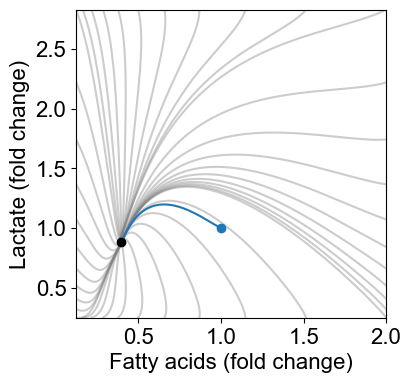

In [7]:

p_clamp = change_parameters(p, e=[2*insulin(1,1,0)], ix=["deltaI"])

vars = [2,1]

log2_concentation_range = [-3,1,-2,1.5]
    

t, basins = basins_of_attratction(p_clamp, vars=vars, log2_concentation_range=log2_concentation_range, 
                                  n_points=11, t_max=1000, concentration_noise=0.0, n_time_points=5000, clamped=True)

f = plt.figure(figsize=(4,4))

steady_states = []  
for basin in basins:
    plt.plot(basin[:,vars[0]], basin[:,vars[1]], 'grey', alpha=0.4 )
    steady_states.append(basin[-1])
# plot the steady state as dots
steady_states = np.array(steady_states)
#plt.plot(steady_states[-1,vars[0]], steady_states[-1,vars[1]], 'ko')
# plto reference state
plt.plot(reference_state(noise=0)[0], reference_state(noise=0 )[1], 'o', color ='C0')

# Plot clamp tracetory 
plt.plot(res_2[:,vars[0]], res_2[:,vars[1]], 'C0', label="Insulin clamp")

plt.plot(res_2[-1,vars[0]], res_2[-1,vars[1]], 'ko')

plt.xlim( 2**log2_concentation_range[0], 2**log2_concentation_range[1])
plt.ylim( 2**log2_concentation_range[2], 2**log2_concentation_range[3])

plt.xlabel('Fatty acids (fold change)')
plt.ylabel('Lactate (fold change)')

plt.savefig('output/basins_of_attraction_lactate_nefa_clamp.svg')



In [8]:
# Random perturbations of the steady state to compute the half-life of the basins of attraction

# Compute randomly sampled basines from 2 fold concentration variation 
def random_basins(x0, parameters, log2_concentation_range=[-1,1], 
                n_points=100, t_max=500,
                     n_time_points=1000, clamped=False):
    
    # Perturbations
    perturbations = 2**np.random.uniform(log2_concentation_range[0], 
                                         log2_concentation_range[1], (4,n_points) ).T * x0
    
    # Time vector
    t = np.linspace(0,t_max,n_time_points)

    # Calculate the trajectories for each of the boundary points
    results = []
    for point in perturbations:
        if clamped:
            result = odeint(equation_clamped,point, t, args=(parameters,))
        else:
            result = odeint(equation,point, t, args=(parameters,))
        results.append(result)

    return t, results

# Compute mean half-life of the L2 norm of the basins of attraction
def compute_t_half(t,basins, x0):
    t_half = []
    for basin in basins:
        # Compute the L2 norm of the basin
        L2_norm = np.linalg.norm(basin-x0, axis=1)
        # Compute the half-life of the L2 norm
        th = np.interp(0.5*L2_norm[0], np.flip(L2_norm), np.flip(t))
        t_half.append(th)

    return np.mean(t_half)




In [11]:
# Compute reference 
x0 = reference_state(noise=0)
p = reference_parameters(concentration_noise=0, flux_noise=0, ki_noise=0)
t, basins = random_basins(x0, p, log2_concentation_range=[-1,1], 
                n_points=100, t_max=50,
                     n_time_points=1000, clamped=False)

mean_t_half0 = compute_t_half(t, basins, x0)

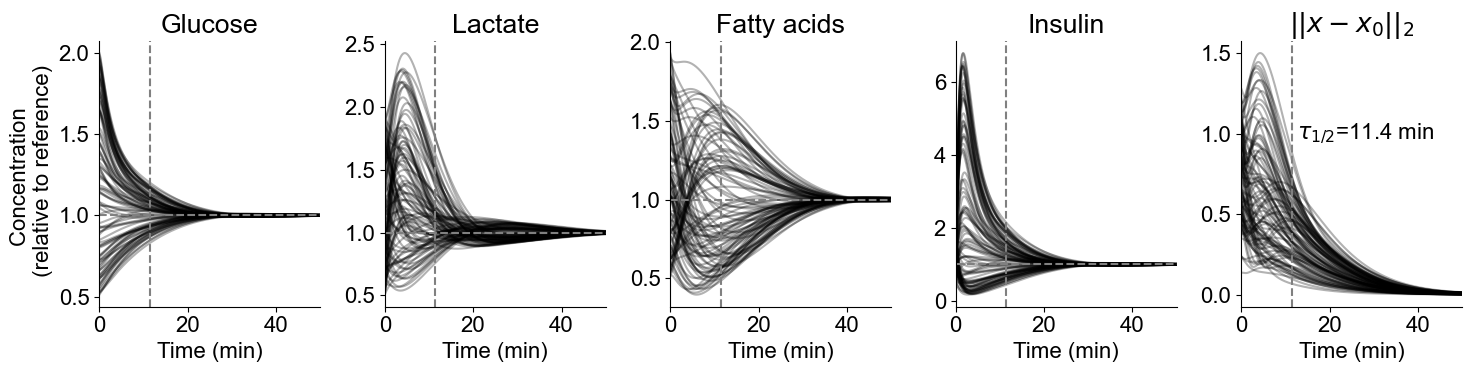

In [12]:
# Plot concentration and the L2 norm as a function of time 
f, ax = plt.subplots(1,5, figsize=(15,4), sharex=True )

for basin in basins:
    ax[0].plot(t, basin[:,0] , color='black', alpha=0.3)
    ax[1].plot(t, basin[:,1] , color='black', alpha=0.3)
    ax[2].plot(t, basin[:,2], color='black', alpha=0.3)
    ax[3].plot(t, basin[:,3]/insulin(1,1,0), color='black', alpha=0.3)
    ax[4].plot(t, np.linalg.norm(basin-x0, axis=1) , color='black', alpha=0.3)

# Add a line for the mean half-life

ax[0].set_ylabel('Concentration \n (relative to reference)')

titles = ['Glucose', 'Lactate', 'Fatty acids', 'Insulin', '$||x-x_0||_2$']
# Limits between 
for i in range(5):
    ax[i].set_title(titles[i])  
    #ax[i].set_ylim(0.0, 4.0)
    ax[i].set_xlim(0, 50)
    ax[i].set_xlabel('Time (min)')
    ax[i].axvline(mean_t_half0, color='grey', linestyle='--')
for i in range(4):
    ax[i].axhline(1, color='grey', linestyle='--')

# Annotate the mean half-life in L2 norm
ax[4].text(mean_t_half0 * 1.1,1.0, '$\\tau_{1/2}$' + f'={mean_t_half0:.1f} min', va='center', ha='left')
sns.despine()
plt.tight_layout()
plt.savefig('output/random_basins_of_attraction.svg')


                    